# Homework 05: Decision Tree Regression
## Kerem Girenes
### April 22, 2022

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def safelog2(x):
    if x == 0:
        return(0)
    else:
        return(np.log2(x))

## Importing Data

In [3]:
train_data = np.genfromtxt("hw05_data_set_train.csv", delimiter=",")
test_data = np.genfromtxt("hw05_data_set_test.csv", delimiter=",")

X_train = train_data[:,0]
y_train = train_data[:,1]

X_test = test_data[:,0]
y_test = test_data[:,1]

## N_train = N_test
N = train_data.shape[0]

## K_train = K_test
K = np.max(y_train)

## Decision Tree Regression Algorithm

In [4]:
def learn_dt(P):
    # create necessary data structures
    node_indices = {}
    is_terminal = {}
    need_split = {}
    
    node_splits = {}
    node_means = {}
    
    # put all training instances into the root node
    node_indices[1] = np.array(range(N))
    is_terminal[1] = False
    need_split[1] = True
    
    # learning algorithm
    while True:
        # find nodes that need splitting
        split_nodes = [key for key, value in need_split.items() if value == True]
        
        # check whether we reach all terminal nodes
        if len(split_nodes) == 0:
            break
            
        # find best split positions for all nodes
        for split_node in split_nodes:
            data_indices = node_indices[split_node]
            need_split[split_node] = False
            node_mean = np.mean(y_train[data_indices])
            
            if len(data_indices) <= P:
                is_terminal[split_node] = True
                node_means[split_node] = node_mean
            else:
                is_terminal[split_node] = False
                unique_values = np.sort(np.unique(X_train[data_indices]))
                split_positions = (unique_values[1:len(unique_values)] + unique_values[0:(len(unique_values) - 1)]) / 2
                split_scores = np.repeat(0.0, len(split_positions))
                
                for s in range(len(split_positions)):
                    left_indices = data_indices[X_train[data_indices] > split_positions[s]]
                    right_indices = data_indices[X_train[data_indices] <= split_positions[s]]
                    
                    split_score = 0.0
                    avg_left = np.mean(y_train[left_indices])
                    avg_right = np.mean(y_train[right_indices])
                    
                    for i in data_indices:
                        if i in left_indices:
                            split_score += (y_train[i] - avg_left) ** 2
                        elif i in right_indices:
                            split_score += (y_train[i] - avg_right) ** 2
                            
                    split_score = split_score / len(data_indices)
                    split_scores[s] = split_score
                    
                node_splits[split_node] = split_positions[np.argmin(split_scores)]
                
                # Left Branch
                left_indices = data_indices[X_train[data_indices] >= node_splits[split_node]]
                node_indices[2 * split_node] = left_indices
                is_terminal[2 * split_node] = False
                need_split[2 * split_node] = True
                
                # Right Branch
                right_indices = data_indices[X_train[data_indices] < node_splits[split_node]]
                node_indices[2 * split_node + 1] = right_indices
                is_terminal[2 * split_node + 1] = False
                need_split[2 * split_node + 1] = True
                
    return is_terminal, node_splits, node_means

## Predict Function

In [5]:
def predict(point, is_terminal, node_splits, node_means):
    index = 1
    while(not is_terminal[index]):
        if point > node_splits[index]:
            index = 2 * index
        else:
            index = 2 * index + 1
    return node_means[index]

## Learn the DT and Plot Figures

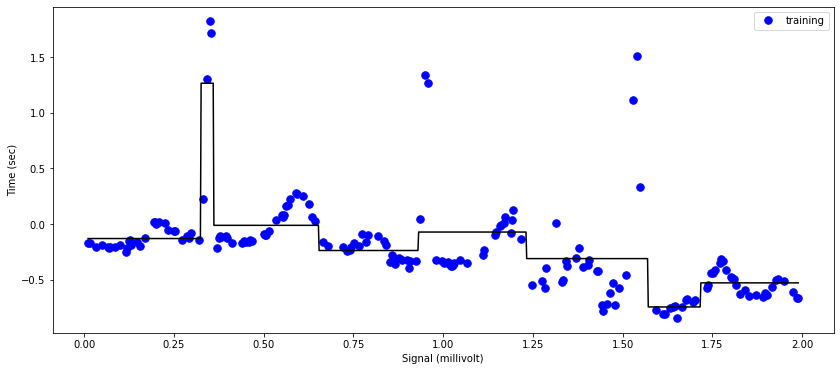

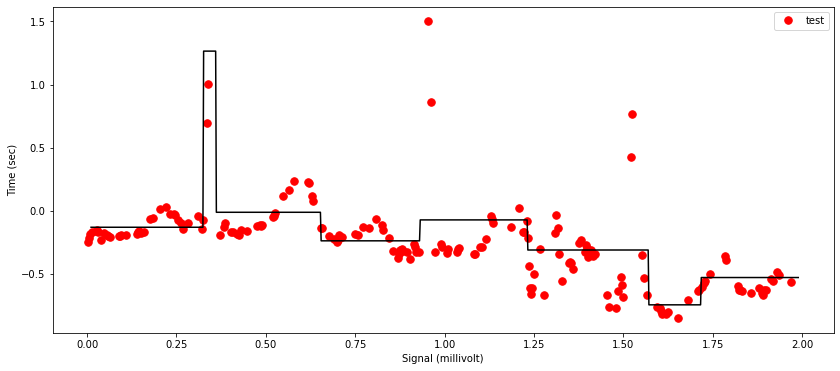

In [6]:
# Learn Decision Tree (Pre-Pruning Parameter = 30)
prep = 30
is_terminal, node_splits, node_means = learn_dt(prep)

# Plot Figures
data_points = np.linspace(np.min(X_train), np.max(X_train), 1000)

y_pred = [predict(d, is_terminal, node_splits, node_means) for d in data_points]

## Training Plot
plt.figure(figsize=(14, 6))
plt.plot(X_train, y_train, "b.", markersize=15, label='training')
plt.plot(data_points, y_pred, "k")
plt.xlabel("Signal (millivolt)")
plt.ylabel("Time (sec)")
plt.legend(loc='upper right')
plt.show()

## Test Plot
plt.figure(figsize=(14, 6))
plt.plot(X_test, y_test, "r.", markersize=15, label='test')
plt.plot(data_points, y_pred, "k")
plt.xlabel("Signal (millivolt)")
plt.ylabel("Time (sec)")
plt.legend(loc='upper right')
plt.show()

## Calculating RMSE

In [7]:
def cal_RMSE(y_pred, y_truth):
    return np.sqrt(np.mean((y_truth - y_pred) ** 2))
                   
y_pred_train = [predict(x, is_terminal, node_splits, node_means) for x in X_train]
y_pred_test = [predict(x, is_terminal, node_splits, node_means) for x in X_test]

print("RMSE on training set is", cal_RMSE(y_pred_train, y_train), "when P is", prep)
print("RMSE on test set is", cal_RMSE(y_pred_test, y_test), "when P is", prep)

RMSE on training set is 0.2881929342801884 when P is 30
RMSE on test set is 0.22542236010134897 when P is 30


## Varying Pre-Pruning Parameter

In [8]:
prep_set = np.arange(10,55,5)
rmse_train_set = np.zeros(len(prep_set))
rmse_test_set = np.zeros(len(prep_set))

for p in range(len(prep_set)):
    is_terminal, node_splits, node_means = learn_dt(prep_set[p])
    y_pred_train = [predict(x, is_terminal, node_splits, node_means) for x in X_train]
    y_pred_test = [predict(x, is_terminal, node_splits, node_means) for x in X_test]
    rmse_train_set[p] = cal_RMSE(y_pred_train, y_train)
    rmse_test_set[p] = cal_RMSE(y_pred_test, y_test)

## Plot Varying-P RMSEs for Training and Test Sets

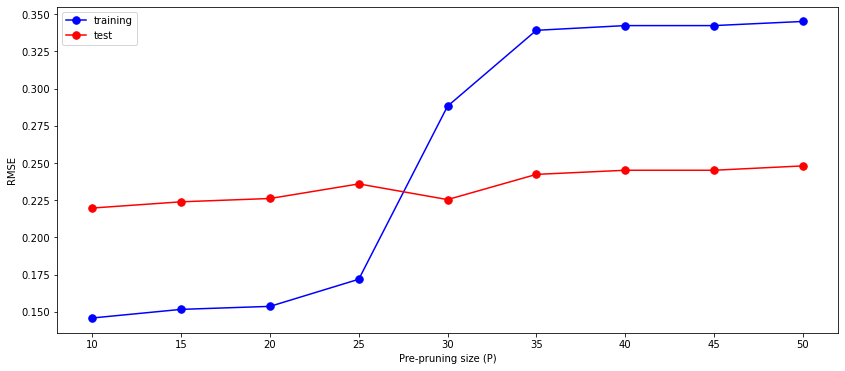

In [9]:
## Plot Training and Test RMSEs together
plt.figure(figsize=(14, 6))
plt.plot(prep_set, rmse_train_set, "b.-", markersize=15, label='training')
plt.plot(prep_set, rmse_test_set, "r.-", markersize=15, label='test')
plt.xlabel("Pre-pruning size (P)")
plt.ylabel("RMSE")
plt.legend(loc='upper left')
plt.show()